In [1]:
from typing import List, Tuple
from functools import lru_cache

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import wandb

In [2]:
sns.set_style('whitegrid')
sns.set_palette('deep')

In [3]:
api = wandb.Api()

In [131]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.set_palette('deep')

In [73]:
def create_dataframe(keys, filters):
  runs = api.runs("gmum/nle", filters=filters)
  data = []
  for run in runs:
    try:
      df = list(run.scan_history(keys=keys))
      df = pd.DataFrame(df)
      df["seed"] = run.config["seed"]
      data.append(df)
    except Exception as e:
      pass

  return pd.concat(data, axis=0).reset_index()

In [92]:
appo_filter = {
    "$or": [
        {"config.exp_tags": ["2023_11_05_monk-APPO"], "config.exp_kind": "eval"},
    ]
}
appo_t_filter = {
    "$or": [
        {"config.exp_tags": ["2023_11_05_monk-APPO-T"], "config.exp_kind": "eval"},
    ]
}
appo_kl_t_filter = {
    "$or": [
        {"config.exp_tags": ["2023_11_05_monk-APPO-AA-KL-T"], "config.exp_kind": "eval"},
    ]
}
appo_ks_t_filter = {
    "$or": [
        {"config.exp_tags": ["2023_11_05_monk-APPO-AA-KS-T"], "config.exp_kind": "eval"},
    ]
}

In [117]:
appo_t_for = create_dataframe(["global/env_train_steps", "eval/mean_forgetting_loss"], appo_t_filter)
appo_kl_t_for = create_dataframe(["global/env_train_steps", "eval/mean_forgetting_loss"], appo_kl_t_filter)
appo_ks_t_for = create_dataframe(["global/env_train_steps", "eval/mean_forgetting_loss"], appo_ks_t_filter)

In [82]:
appo_df = create_dataframe(["eval/mean_episode_return", "global/env_train_steps"], appo_filter)
appo_t_df = create_dataframe(["eval/mean_episode_return", "global/env_train_steps"], appo_t_filter)
appo_kl_t_df = create_dataframe(["eval/mean_episode_return", "global/env_train_steps"], appo_kl_t_filter)
appo_ks_t_df = create_dataframe(["eval/mean_episode_return", "global/env_train_steps"], appo_ks_t_filter)

In [123]:
appo_t_for["index"] = (np.round(appo_t_for['global/env_train_steps'] / 100_000_000) * 100_000_000).astype(int)
appo_kl_t_for["index"] = (np.round(appo_kl_t_for['global/env_train_steps'] / 100_000_000) * 100_000_000).astype(int)
appo_ks_t_for["index"] = (np.round(appo_ks_t_for['global/env_train_steps'] / 100_000_000) * 100_000_000).astype(int)

In [87]:
appo_df["index"] = (np.round(appo_df['global/env_train_steps'] / 100_000_000) * 100_000_000).astype(int)
appo_t_df["index"] = (np.round(appo_t_df['global/env_train_steps'] / 100_000_000) * 100_000_000).astype(int)
appo_kl_t_df["index"] = (np.round(appo_kl_t_df['global/env_train_steps'] / 100_000_000) * 100_000_000).astype(int)
appo_ks_t_df["index"] = (np.round(appo_ks_t_df['global/env_train_steps'] / 100_000_000) * 100_000_000).astype(int)

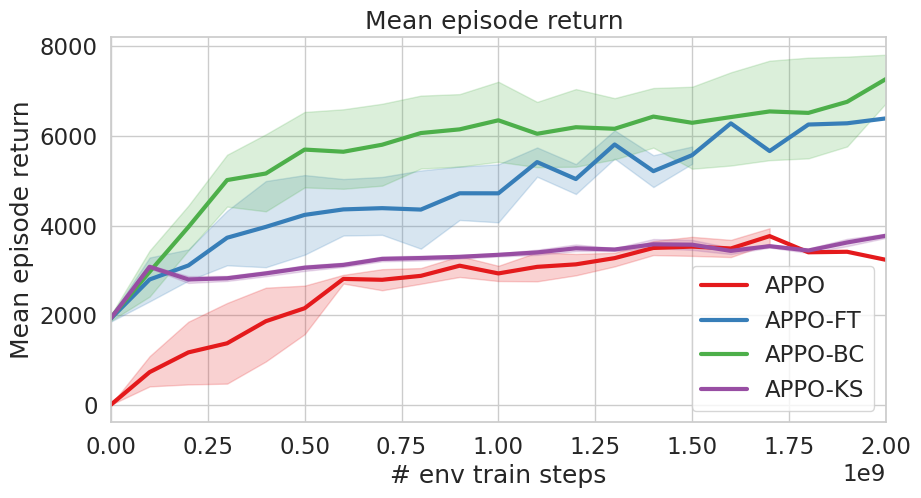

In [136]:
color_palette = sns.color_palette("Set1", 4)

fig, axes = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(data=appo_df, x="index", y="eval/mean_episode_return", ax=axes, errorbar=('ci', 90), linewidth=3, legend="full", label="APPO", color=color_palette[0])
sns.lineplot(data=appo_t_df, x="index", y="eval/mean_episode_return", ax=axes, errorbar=('ci', 90), linewidth=3, legend="full", label="APPO-FT", color=color_palette[1])
sns.lineplot(data=appo_kl_t_df, x="index", y="eval/mean_episode_return", ax=axes, errorbar=('ci', 90), linewidth=3, legend="full", label="APPO-BC", color=color_palette[2])
sns.lineplot(data=appo_ks_t_df, x="index", y="eval/mean_episode_return", ax=axes, errorbar=('ci', 90), linewidth=3, legend="full", label="APPO-KS", color=color_palette[3])

# sns.lineplot(data=appo_t_for, x="index", y="eval/mean_forgetting_loss", ax=axes[1], errorbar=('ci', 90), linewidth=3, legend=False, label="APPO-FT", color=color_palette[1])
# sns.lineplot(data=appo_kl_t_for, x="index", y="eval/mean_forgetting_loss", ax=axes[1], errorbar=('ci', 90), linewidth=3, legend=False, label="APPO-BC", color=color_palette[2])
# sns.lineplot(data=appo_ks_t_for, x="index", y="eval/mean_forgetting_loss", ax=axes[1], errorbar=('ci', 90), linewidth=3, legend=False, label="APPO-KS", color=color_palette[3])

axes.set_xlabel("# env train steps")
axes.set_xlim(0, 2_000_000_000)

axes.set_title("Mean episode return ")
axes.set_ylabel("Mean episode return")

# axes[1].set_title("KL div on data generated by teacher")
# axes[1].set_ylabel("Kullback-Leibler Divergence")

plt.show(fig)